# Assignment 4 - Neural Networks

 Name: **Mohammad Abu-Shelbaia**
 <br>
 ID: **1200198**

## **Loading the data**

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

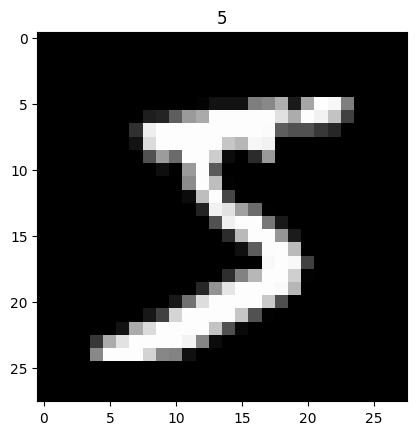

In [2]:
from cv2 import imshow


img, label = training_data[0]

plt.imshow(img.squeeze(), cmap='gray')
print(img.shape)
plt.title(label)



## **Build the network**

In [3]:
_,ABC,D,X,Y = 1, 200, 1, 9, 8
print(ABC,D,X,Y)

from sympy import flatten
import torch.nn as nn
import torch.nn.functional as F
class NetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, X+4, 3)
        self.conv2 = nn.Conv2d(X+4, Y+15, 3)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.fc1 = nn.Linear(575, ABC)
        self.fc2 = nn.Linear(ABC, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
net = NetCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print(net)

200 1 9 8
NetCNN(
  (conv1): Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(13, 23, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=575, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


### **Loss Function & Optmizer**

In [4]:
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)


## **Train the network**

In [5]:
tau = 20 / 7.0
train_loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)


In [9]:
net.train()
accuracy = []
ephocs = [i for i in range(3)]
for epoch in range(3): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        # convert labels to 0 and 1 depending whether they are greater than tau or not
        labels = (labels > tau).to(torch.float32).to(device)
        labels = labels.unsqueeze(1)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0  

    # Calculate accuracy for the epoch
    epoch_accuracy = 100 * correct / total
    accuracy.append(epoch_accuracy)




[1,  2000] loss: 0.010
[1,  4000] loss: 0.012
[1,  6000] loss: 0.010
[2,  2000] loss: 0.008
[2,  4000] loss: 0.008
[2,  6000] loss: 0.011
[3,  2000] loss: 0.008
[3,  4000] loss: 0.007
[3,  6000] loss: 0.007


## **Plot the training accuracy**

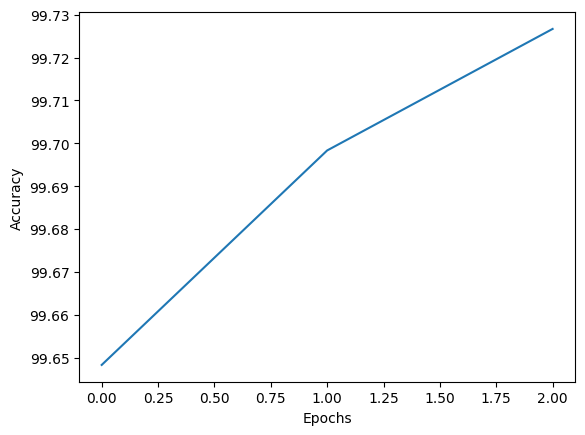

In [12]:
# plot accuracy vs ephocs
plt.plot(ephocs, accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [13]:


correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = (labels > tau).to(torch.float32).to(device)
        labels = labels.unsqueeze(1)
        outputs = net(images)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 99.63%


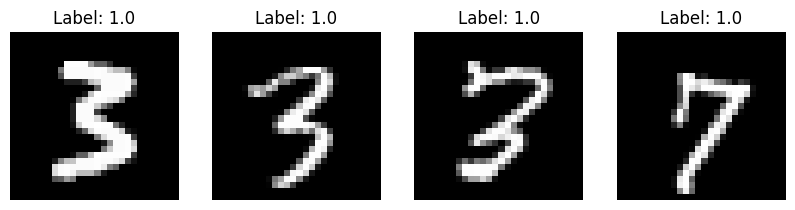

In [41]:
# plot four misclassified images
net.eval()
images_x = []
labels_x  = []
count = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = (labels > tau).to(torch.float32).to(device)
        labels = labels.unsqueeze(1)
        outputs = net(images)
        predicted = torch.round(outputs)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                count += 1
                images_x.append(images[i])
                labels_x.append(labels[i])
                if count == 4:
                    break
        if count == 4:
            break

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')